<a href="https://colab.research.google.com/github/megantennies/AIF360/blob/master/NB_Weds_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Advanced Natural Language Engineering (G5114)**

Practical Assignment: The Microsoft Research Sentence Completion Challenge

## Data Imports

In [81]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize as tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
from nltk.corpus import stopwords 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [106]:
import csv, os, random, math, itertools, operator
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
from tqdm import tqdm
from IPython.display import display, Markdown

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

## Data Collection

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
TRAINING_DIR = '/content/drive/MyDrive/Colab Notebooks/sentence-completion/Holmes_Training_Data'

**Splitting the Sherlock Holmes training files into sets for training and testing** 

In [6]:
def get_training_testing(training_dir = TRAINING_DIR, split = 0.5):
  filenames = os.listdir(training_dir)
  n = len(filenames)
  print('There are {} files in the training directory: {}'.format(n, training_dir))
  random.shuffle(filenames)
  index = int(n * split)
  return(filenames[:index], filenames[index:])

In [9]:
trainingfiles, testingfiles = get_training_testing()
print('There are {} files for training.'.format(len(trainingfiles)))
print('There are {} files for testing.'.format(len(testingfiles)))

There are 522 files in the training directory: /content/drive/MyDrive/Colab Notebooks/sentence-completion/Holmes_Training_Data
There are 261 files for training.
There are 261 files for testing.


## Higher N-Gram Language Models

This class creates an N-gram language model, using unigrams, bigrams, or trigrams.

**Unigram Model**

Given a sequence of words, $ W $, and unigram model will output the probability:

$$ P(W) = P(w_{1}) P(w_{2}) ... P(w_{n}) $$

Where the individual probabilities $ P(w_{i}) $ can be estimated based on the frequency of words in the training corpus. 

**Bigram Model**

Instead, a bigram model will look at the previous word to estimate the next one, so that:

$$ P(W) = P(w_{1}) P(w_{2}|w_{1}) P(w_{3}|w_{2})... P(w_{n}|w_{n-1})  $$

**Trigram Model**

As a rule, an N-gram model will look at the previous $ (n-1) $ words to estimate the next one. A trigram model will look at the previous *2* words, so that:

$$ P(W) = P(w_{1}) P(w_{2}|w_{1}) P(w_{3}|w_{2}, w_{1})... P(w_{n}|w_{n-1}, w_{n-2})  $$

In [118]:
class language_model():
  def __init__(self, trainingdir = TRAINING_DIR, files = []):
    self.training_dir = trainingdir
    self.files = files
    self.train()
      
  def train(self):    
    self.unigram = {}
    self.bigram = {}
    self.trigram = {}
    self._processfiles()
    self._make_unknowns()
    self._discount()
    self._convert_to_probs()

  def _remove_punct(self, token):
    # removing punctuation
    punctuation = '.' + ',' + ':' + ';' + '...' + '"' + '"' + '-' + '’' + \
      '‘' + '—' + '?' + '!' + '(' + ')'
    removal_list = list(punctuation)
    if token in removal_list:
      token.replace(token, '')

  def _remove_stopwords(self, token):
  # removing stopwords
    stop_words = set(stopwords.words('english'))
    removed = []
    if token not in stop_words:
      tokens = removed.append(token)

  # processing each line of each file to create tokens (words)    
  def _processline(self, line):
    tokens = ['<s>'] + tokenize(line) + ['</s>']
    bi_previous = '</s>'
    for i, token in enumerate(tokens):
      self._remove_punct(token)
      self._remove_stopwords(token)
      self.unigram[token] = self.unigram.get(token, 0) + 1
      bi_current = self.bigram.get(bi_previous, {})
      bi_current[token] = bi_current.get(token, 0) + 1
      self.bigram[bi_previous] = bi_current
      if i >= 1:
        bi_previous = tokens[i - 1]
      if i >= 2:
        tri_previous = tokens[i-2]
        tri_current = self.trigram.get(tri_previous, {})
        tri_current_ = tri_current.get(bi_previous, {})
        tri_current_[token] = tri_current_.get(token, 0) + 1
        tri_current[bi_previous] = tri_current_
        self.trigram[tri_previous] = tri_current

  def _processfiles(self):
    for afile in tqdm(self.files):
      print('Processing {}'.format(afile))
      try:
        with open(os.path.join(self.training_dir, afile)) as instream:
          for line in instream:
            line = line.rstrip()
            if len(line) > 0:
              self._processline(line)
      except UnicodeDecodeError:
        print('UnicodeDecodeError processing {}: ignoring rest of file'.format(afile))
      
  def _convert_to_probs(self):
    self.unigram = {k: v/sum(self.unigram.values()) 
      for (k, v) in self.unigram.items()}
    self.bigram = {key: {k: v/sum(adict.values()) 
      for (k, v) in adict.items()} for (key, adict) in self.bigram.items()}
    self.trigram = {key2: {key: {k: v/sum(adict.values()) 
      for (k, v) in adict.items()} for (key, adict) in dict2.items()} 
      for (key2, dict2) in self.trigram.items()}
    self.kn = {k: v/sum(self.kn.values()) for (k, v) in self.kn.items()}
      
  def get_prob(self, context, token, methodparams = {}):
    if methodparams.get('method', 'unigram') == 'unigram':
      return self.unigram.get(token, self.unigram.get('<unk>', 0))
    else:
      if methodparams.get('smoothing', 'kneser-ney') == 'kneser-ney' and \
        methodparams.get('method', 'bigram') == 'bigram':
          unidist = self.kn
          token = ''.join(token)
          bigram = self.bigram.get(context, self.bigram.get('<unk>', {}))
          big_p = bigram.get(token, bigram.get('<unk>', 0))
          lmbda = bigram['<disc>']
          uni_p = unidist.get(token, unidist.get('<unk>', 0))
          p = big_p + lmbda * uni_p
          return p
      elif methodparams.get('method', 'trigram') == 'trigram' and \
        methodparams.get('smoothing', 'kneser-ney') == 'kneser-ney':
          unidist = self.kn
          token = ''.join(token)
          trigram = self.trigram.get(context, self.trigram.get('<unk>', {}))
          tri_p = trigram.get(token, trigram.get('<unk>', 0))
          #lmbda = trigram['<disc>']
          #big_p = unidist.get(token, tri_p.get('<unk>', 0))
          #p = tri_p + lmbda * big_p
          return tri_p
  
  def nextlikely(self, k = 1, current = '', method = 'unigram'):
    blacklist = ['<s>', '<disc>']
    if method == 'unigram':
      dist = self.unigram
    else:
      dist = self.bigram.get(current, self.bigram.get('<unk>', {}))
    mostlikely = list(dist.items())
    #filter out any undesirable tokens
    filtered = [(w, p) for (w, p) in mostlikely if w not in blacklist]
    #choose one randomly from the top k
    words, probdist = zip(*filtered)
    res = random.choices(words, probdist)[0]
    return res
  
  def generate(self, k = 1, end = '</s>', limit = 20, method = 'trigram', 
               methodparams = {}):
    current = '<s>'
    tokens = []
    if method == '':
      method = methodparams.get('method', 'trigram')
    while current != end and len(tokens) < limit:
      current = self.nextlikely(k = k, current = current, method = method)
      tokens.append(current)
    return ' '.join(tokens[:-1])
  
  def compute_prob_line(self, line, methodparams = {}):
    #this will add _start to the beginning of a line of text
    #compute the probability of the line according to the desired model
    #and returns probability together with number of tokens
    tokens = ['<s>'] + tokenize(line) + ['</s>']
    acc = 0
    for i, token in enumerate(tokens[1:]):
      acc += math.log(self.get_prob(tokens[:i+1], token, methodparams))
    return acc, len(tokens[1:])
  
  def compute_probability(self, filenames = [], methodparams = {}):
    #computes the probability (and length) of a corpus contained in filenames
    if filenames == []:
      filenames = self.files
    total_p = 0
    total_N = 0
    for i, afile in enumerate(filenames):
      print('Processing file {}:{}'.format(i, afile))
      try:
        with open(os.path.join(self.training_dir, afile)) as instream:
          for line in instream:
            line = line.rstrip()
            if len(line) > 0:
              p, N = self.compute_prob_line(line, methodparams = methodparams)
              total_p += p
              total_N += N
      except UnicodeDecodeError:
        print('UnicodeDecodeError processing file {}: ignoring rest of file'.format(afile))
    return total_p, total_N
  
  def compute_perplexity(self, filenames = [], 
                         methodparams = {'method': 'bigram', 'smoothing': 'kneser-ney'}):
    #compute the probability and length of the corpus
    #calculate perplexity
    #lower perplexity means that the model better explains the data
    p, N = self.compute_probability(filenames = filenames, methodparams = methodparams)
    #print(p,N)
    pp = math.exp(-p / N)
    return pp  
  
  def _make_unknowns(self, known = 2):
    unknown = 0
    for (k, v) in list(self.unigram.items()):
      if v < known:
        del self.unigram[k]
        self.unigram['<unk>'] = self.unigram.get('<unk>', 0) + v
    for (k, adict) in list(self.bigram.items()):
      for (kk, v) in list(adict.items()):
        isknown = self.unigram.get(kk, 0)
        if isknown == 0:
          adict['<unk>'] = adict.get('<unk>', 0) + v
          del adict[kk]
      isknown = self.unigram.get(k, 0)
      if isknown == 0:
        del self.bigram[k]
        current = self.bigram.get('<unk>', {})
        current.update(adict)
        self.bigram['<unk>'] = current
      else:
        self.bigram[k] = adict
              
  def _discount(self, discount = 0.75):
    #discount each bigram count by a small fixed amount
    self.bigram = {k: {kk: value-discount for (kk, value) in adict.items()} 
                   for (k, adict) in self.bigram.items()}
    #for each word, store the total amount of the discount so that the total is the same 
    #i.e., so we are reserving this as probability mass
    for k in self.bigram.keys():
      lamb = len(self.bigram[k])
      self.bigram[k]['<disc>'] = lamb * discount
    #work out kneser-ney unigram probabilities
    #count the number of contexts each word has been seen in
    self.kn = {}
    for (k, adict) in self.bigram.items():
      for kk in adict.keys():
        self.kn[kk] = self.kn.get(kk, 0) + 1

## Building the Sentence Completion Challenge (SCC) Reader 

**Loading in the SCC Questions & Answers** 

In [10]:
PARENT_DIR = '/content/drive/MyDrive/Colab Notebooks/sentence-completion'

In [11]:
questions = os.path.join(PARENT_DIR, 'testing_data.csv')
answers = os.path.join(PARENT_DIR, 'test_answer.csv')

In [12]:
with open(questions) as instream:
  csvreader = csv.reader(instream)
  lines = list(csvreader)
qs_df = pd.DataFrame(lines[1:], columns = lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [72]:
tokens = [tokenize(q) for q in qs_df['question']]
print(tokens[:1])

[['I', 'have', 'it', 'from', 'the', 'same', 'source', 'that', 'you', 'are', 'both', 'an', 'orphan', 'and', 'a', 'bachelor', 'and', 'are', '_____', 'alone', 'in', 'London', '.']]


In [129]:
class question:
  def __init__(self, aline):
    self.fields = aline
  
  def get_field(self, field):
    return self.fields[question.colnames[field]]

  def get_tokens(self):
    return ['<s>'] + tokenize(self.fields[question.colnames['question']]) + ['</s>']
  
  def get_left_context(self, window = 1, target = '_____'):
    found = -1
    sent_tokens = self.get_tokens()
    for i, token in enumerate(sent_tokens):
      if token == target:
        found = i
        break
    sent = sent_tokens[i - window: i] 
    if found > -1:
      sentence = ' '.join(sent)
      return sentence
    else:
      return []

  def get_right_context(self, window = 1, target = '_____'):
    found = -1
    sent_tokens = self.get_tokens()
    for i, token in enumerate(sent_tokens):
      if token == target:
        found = i
        break  
    if found > -1:
      return sent_tokens[found+1: found+window+1]
    else:
      return []
  
  def add_answer(self, fields):
    self.answer = fields[1]
  
  def chooseA(self):
    return('a')

  def chooserandom(self):
    choices = ['a', 'b', 'c', 'd', 'e']
    return np.random.choice(choices)

  def chooseunigram(self, lm):
    choices = ['a', 'b', 'c', 'd', 'e']      
    probs = [lm.unigram.get(self.get_field(ch + ')'), 0) for ch in choices]
    maxprob = max(probs)
    bestchoices = [ch for ch, prob in zip(choices, probs) if prob == maxprob]
    #if len(bestchoices)>1:
    #    print('Randomly choosing from {}'.format(len(bestchoices)))
    return np.random.choice(bestchoices)

  def choose_backoff(self, lm, methods = ['bigram', 'unigram'], 
                     choices = ['a', 'b', 'c', 'd', 'e']):
    context = self.get_left_context(window = 1)
    probs = [lm.get_prob(context, self.get_field(ch + ')'), 
                         methodparams = {'method': methods[0]}) for ch in choices]
    maxprob = max(probs)
    bestchoices = [ch for ch, prob in zip(choices, probs) if prob == maxprob]
    # if len(bestchoices)>1:
    #     print('Backing off on {}'.format(len(bestchoices)))
    return self.choose(lm, choices = bestchoices, method = methods[1])

  def choose(self, lm, method = 'trigram', choices = ['a', 'b', 'c', 'd', 'e']):
    if choices == []:
      choices = ['a', 'b', 'c', 'd', 'e']
    if method == 'unigram':
      return self.chooseunigram(lm)
    if method == 'bigram':
      rc = self.get_right_context(window = 1)
      lc = self.get_left_context(window = 1)
      probs = [lm.get_prob(lc, [self.get_field(ch + ')')], 
                           methodparams = {'method': method.split('_')[0]}) * 
               lm.get_prob(self.get_field(ch + ')'), lc, 
                           methodparams = {'method': method.split('_')[0]}) for ch in choices]
      maxprob = max(probs)
      bestchoices = [ch for ch, prob in zip(choices, probs) if prob == maxprob]
      return np.random.choice(bestchoices)
    elif method == 'trigram':
      rc = self.get_right_context(window = 2)
      lc = self.get_left_context(window = 2)
      probs = [lm.get_prob(lc, [self.get_field(ch + ')')], 
                           methodparams = {'method': method.split('_')[0]}) * 
               lm.get_prob(self.get_field(ch + ')'), lc, 
                           methodparams = {'method': method.split('_')[0]}) for ch in choices]
      maxprob = max(probs)
      bestchoices = [ch for ch, prob in zip(choices, probs) if prob == maxprob]
      return np.random.choice(bestchoices)

  def predict(self, method, lm = mylm):
    if method == 'chooseA':
      return self.chooseA()
    elif method == 'random':
      return self.chooserandom()
    elif method == 'bigram':
      return self.choose(lm, method = 'bigram')
    elif method == 'bigram_backoff':
      return self.choose_backoff(lm, methods = ['unigram', 'bigram'])
    elif method == "trigram":
      return self.choose(lm, method = 'trigram')
      # return self.choose(trigram_model)
    else:
      return self.choose(lm, method = method)

  def predict_and_score(self, method):
    #compare prediction according to method with the correct answer
    #return 1 or 0 accordingly
    prediction = self.predict(method = method)
    if prediction == self.answer:
      return 1
    else:
      return 0

In [37]:
class scc_reader:
  def __init__(self, qs = questions, ans = answers):
    self.qs = qs
    self.ans = ans
    self.read_files()
    
  def read_files(self):
    #read in the question file
    with open(self.qs) as instream:
      csvreader = csv.reader(instream)
      qlines = list(csvreader)
    #store the column names as a reverse index so they can be used to reference parts of the question
    question.colnames = {item: i for i, item in enumerate(qlines[0])}
    #create a question instance for each line of the file (other than heading line)
    self.questions = [question(qline) for qline in qlines[1:]]
    #read in the answer file
    with open(self.ans) as instream:
      csvreader = csv.reader(instream)
      alines = list(csvreader)
    #add answers to questions so predictions can be checked    
    for q, aline in zip(self.questions, alines[1:]):
      q.add_answer(aline)
    
  def get_field(self, field):
    return [q.get_field(field) for q in self.questions] 
  
  def predict(self, method):
    return [q.predict(method = method) for q in self.questions]
  
  def predict_and_score(self, method):
    scores = [q.predict_and_score(method = method) for q in self.questions]
    return sum(scores) / len(scores)

## N-Gram Model Evaluation 

In [119]:
MAX_FILES = 5
filesets = {'training': trainingfiles[:MAX_FILES], 'testing': testingfiles[:MAX_FILES]}
methods = [{'method': 'unigram'}, {'method': 'bigram', 'smoothing': 'katz'}, 
           {'method': 'bigram', 'smoothing': 'kneser-ney'}]
mylm = language_model(files = filesets['training'])

  0%|          | 0/5 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 20%|██        | 1/5 [00:09<00:37,  9.39s/it]

Processing 10EVM10.TXT


 40%|████      | 2/5 [00:43<01:11, 23.98s/it]

Processing TCNTR10.TXT


 60%|██████    | 3/5 [00:50<00:32, 16.25s/it]

Processing AGENT10.TXT


 80%|████████  | 4/5 [01:15<00:19, 19.75s/it]

Processing BBETC10.TXT


100%|██████████| 5/5 [01:39<00:00, 19.93s/it]


**Displaying prediction results** 

In [85]:
SCC = scc_reader()
qs_df['random_pred'] = SCC.predict(method = 'random')
qs_df['chooseA_pred'] = SCC.predict(method = 'chooseA')
qs_df['unigram_pred'] = SCC.predict(method = 'unigram')
qs_df['bigram_pred'] = SCC.predict(method = 'bigram')
qs_df['trigram_pred'] = SCC.predict(method = 'trigram')
qs_df = qs_df[['id', 'question', 'a)', 'b)', 'c)', 'd)', 'e)', 'random_pred', 
               'chooseA_pred', 'unigram_pred', 'bigram_pred', 'trigram_pred']]
qs_df.head()

,id,question,a),b),c),d),e),random_pred,chooseA_pred,unigram_pred,bigram_pred,trigram_pred
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,c,a,e,e,c
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,e,a,e,a,d
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,e,a,b,d,e
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,b,a,c,d,e
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,e,a,c,c,b


In [53]:
with open(answers) as instream:
  csvreader = csv.reader(instream)
  q_answers = list(csvreader)

In [87]:
ans_df = pd.DataFrame(q_answers[1:], columns = q_answers[0])
results = pd.concat([qs_df, ans_df['answer']], axis = 1)
results = results[['id', 'question', 'a)', 'b)', 'c)', 'd)', 'e)', 'answer', 
                   'random_pred', 'chooseA_pred', 'unigram_pred', 'bigram_pred', 
                   'trigram_pred']]
results.head()

,id,question,a),b),c),d),e),answer,random_pred,chooseA_pred,unigram_pred,bigram_pred,trigram_pred
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,c,c,a,e,e,c
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,a,e,a,e,a,d
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,d,e,a,b,d,e
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,c,b,a,c,d,e
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,d,e,a,c,c,b


#### Evaluation Metric: Predictive Accuracy



In [159]:
def score_accuracy(methods = []):
  SCC = scc_reader()
  acc_scores = {'Method': [], 'Accuracy': []}
  for method in methods:
    acc_score = SCC.predict_and_score(method = method)
    display(Markdown('#### Method: {}'.format(method)))
    print('Accuracy: {}'.format(acc_score))
    acc_scores['Method'].append(method)
    acc_scores['Accuracy'].append(acc_score)
  return acc_scores

In [162]:
methods = ['random', 'chooseA', 'unigram', 'bigram', 'bigram_backoff', 'trigram']

In [163]:
acc_scores = score_accuracy(methods = methods)

#### Method: random

Accuracy: 0.18173076923076922


#### Method: chooseA

Accuracy: 0.19903846153846153


#### Method: unigram

Accuracy: 0.2567307692307692


#### Method: bigram

Accuracy: 0.19903846153846153


#### Method: bigram_backoff

Accuracy: 0.20673076923076922


#### Method: trigram

Accuracy: 0.19038461538461537


**Plotting predictive accuracy for each N-gram model**

Text(0.5, 1.0, 'Average Predictive Accuracy Scores for each N-Gram model')

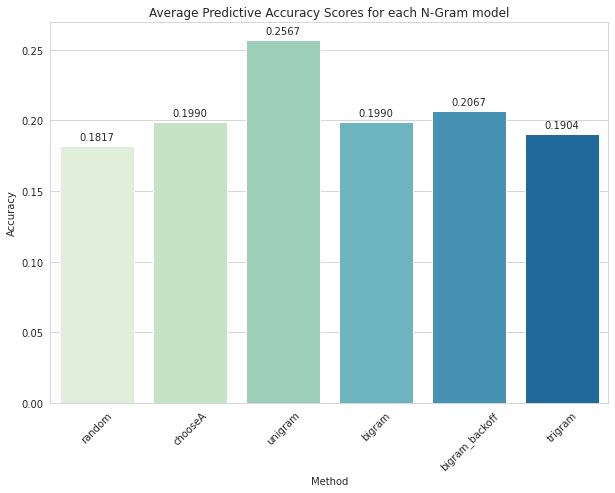

In [258]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Method', y = 'Accuracy', data = acc_scores, palette = 'GnBu')
for val in ax.patches:
  ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., 
                                                val.get_height()), 
    ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
plt.xticks(rotation = 45)
plt.title('Average Predictive Accuracy Scores for each N-Gram model')

**Plotting predictive accuracy for each N-gram model dependant on training data size** 

In [181]:
def training_size(filesizes = (), methods = []):
  size_scores = {'Unigram': {'Number of training files': [], 'Accuracy': []},
                 'Bigram': {'Number of training files': [], 'Accuracy': []},
                 'Trigram': {'Number of training files': [], 'Accuracy': []}}
  for method in methods:
    if method == 'unigram':
      for size in filesizes:
        mylm = language_model(files = trainingfiles[:size])
        SCC = scc_reader()
        acc_score = SCC.predict_and_score(method = method)
        size_scores['Unigram']['Number of training files'].append(size)
        size_scores['Unigram']['Accuracy'].append(acc_score)
    if method == 'bigram':
      for size in filesizes:
        mylm = language_model(files = trainingfiles[:size])
        SCC = scc_reader()
        acc_score = SCC.predict_and_score(method = method)
        size_scores['Bigram']['Number of training files'].append(size)
        size_scores['Bigram']['Accuracy'].append(acc_score)
    if method == 'trigram':
      for size in filesizes:
        mylm = language_model(files = trainingfiles[:size])
        SCC = scc_reader()
        acc_score = SCC.predict_and_score(method = method)
        size_scores['Trigram']['Number of training files'].append(size)
        size_scores['Trigram']['Accuracy'].append(acc_score)           
  return size_scores

In [182]:
filesizes = (1, 5, 10, 15) # this cell took 35 mins 45 secs to run
methods = ('unigram' , 'bigram', 'trigram')
small_size_scores = training_size(filesizes = filesizes, methods = methods)

  0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


  0%|          | 0/5 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 20%|██        | 1/5 [00:14<00:56, 14.16s/it]

Processing 10EVM10.TXT


 40%|████      | 2/5 [00:48<01:17, 25.93s/it]

Processing TCNTR10.TXT


 60%|██████    | 3/5 [00:55<00:34, 17.14s/it]

Processing AGENT10.TXT


 80%|████████  | 4/5 [01:23<00:21, 21.80s/it]

Processing BBETC10.TXT


  0%|          | 0/10 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 10%|█         | 1/10 [00:08<01:18,  8.77s/it]

Processing 10EVM10.TXT


 20%|██        | 2/10 [00:40<02:59, 22.47s/it]

Processing TCNTR10.TXT


 30%|███       | 3/10 [00:47<01:46, 15.25s/it]

Processing AGENT10.TXT


 40%|████      | 4/10 [01:11<01:51, 18.61s/it]

Processing BBETC10.TXT


 50%|█████     | 5/10 [01:34<01:40, 20.12s/it]

Processing HYDEA10.TXT


 60%|██████    | 6/10 [01:41<01:02, 15.67s/it]

Processing TDITW10.TXT


 70%|███████   | 7/10 [01:52<00:43, 14.38s/it]

Processing FLIRT10.TXT


 80%|████████  | 8/10 [02:13<00:32, 16.29s/it]

Processing 3DFRE10.TXT


 90%|█████████ | 9/10 [03:20<00:32, 32.19s/it]

Processing LSUSN10.TXT


  0%|          | 0/15 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


  7%|▋         | 1/15 [00:08<02:02,  8.78s/it]

Processing 10EVM10.TXT


 13%|█▎        | 2/15 [00:40<04:51, 22.42s/it]

Processing TCNTR10.TXT


 20%|██        | 3/15 [00:47<03:02, 15.23s/it]

Processing AGENT10.TXT


 27%|██▋       | 4/15 [01:11<03:23, 18.53s/it]

Processing BBETC10.TXT


 33%|███▎      | 5/15 [01:33<03:19, 19.96s/it]

Processing HYDEA10.TXT


 40%|████      | 6/15 [01:40<02:19, 15.52s/it]

Processing TDITW10.TXT


 47%|████▋     | 7/15 [01:51<01:53, 14.16s/it]

Processing FLIRT10.TXT


 53%|█████▎    | 8/15 [02:11<01:51, 15.99s/it]

Processing 3DFRE10.TXT


 60%|██████    | 9/15 [03:17<03:09, 31.54s/it]

Processing LSUSN10.TXT


 67%|██████▋   | 10/15 [03:23<01:58, 23.65s/it]

Processing PCLEV10.TXT


 73%|███████▎  | 11/15 [03:38<01:24, 21.06s/it]

Processing SAWYR10.TXT


 80%|████████  | 12/15 [03:58<01:02, 20.72s/it]

Processing TWILS10.TXT


 87%|████████▋ | 13/15 [04:08<00:35, 17.55s/it]

Processing DGOLD10.TXT


 93%|█████████▎| 14/15 [04:36<00:20, 20.63s/it]

Processing WELND10.TXT


  0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


  0%|          | 0/5 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 20%|██        | 1/5 [00:08<00:35,  8.78s/it]

Processing 10EVM10.TXT


 40%|████      | 2/5 [00:43<01:12, 24.09s/it]

Processing TCNTR10.TXT


 60%|██████    | 3/5 [00:50<00:32, 16.11s/it]

Processing AGENT10.TXT


 80%|████████  | 4/5 [01:21<00:22, 22.08s/it]

Processing BBETC10.TXT


  0%|          | 0/10 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 10%|█         | 1/10 [00:08<01:18,  8.77s/it]

Processing 10EVM10.TXT


 20%|██        | 2/10 [00:43<03:11, 23.99s/it]

Processing TCNTR10.TXT


 30%|███       | 3/10 [00:55<02:10, 18.64s/it]

Processing AGENT10.TXT


 40%|████      | 4/10 [01:29<02:27, 24.52s/it]

Processing BBETC10.TXT


 50%|█████     | 5/10 [01:55<02:06, 25.29s/it]

Processing HYDEA10.TXT


 60%|██████    | 6/10 [02:02<01:16, 19.06s/it]

Processing TDITW10.TXT


 70%|███████   | 7/10 [02:16<00:51, 17.23s/it]

Processing FLIRT10.TXT


 80%|████████  | 8/10 [02:38<00:37, 18.74s/it]

Processing 3DFRE10.TXT


 90%|█████████ | 9/10 [04:17<00:43, 43.99s/it]

Processing LSUSN10.TXT


  0%|          | 0/15 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


  7%|▋         | 1/15 [00:10<02:33, 10.94s/it]

Processing 10EVM10.TXT


 13%|█▎        | 2/15 [00:48<05:46, 26.67s/it]

Processing TCNTR10.TXT


 20%|██        | 3/15 [00:55<03:30, 17.55s/it]

Processing AGENT10.TXT


 27%|██▋       | 4/15 [01:30<04:27, 24.32s/it]

Processing BBETC10.TXT


 33%|███▎      | 5/15 [02:02<04:31, 27.15s/it]

Processing HYDEA10.TXT


 40%|████      | 6/15 [02:11<03:09, 21.10s/it]

Processing TDITW10.TXT


 47%|████▋     | 7/15 [02:23<02:23, 17.95s/it]

Processing FLIRT10.TXT


 53%|█████▎    | 8/15 [02:42<02:10, 18.59s/it]

Processing 3DFRE10.TXT


 60%|██████    | 9/15 [04:02<03:46, 37.76s/it]

Processing LSUSN10.TXT


 67%|██████▋   | 10/15 [04:08<02:19, 27.97s/it]

Processing PCLEV10.TXT


 73%|███████▎  | 11/15 [04:24<01:36, 24.08s/it]

Processing SAWYR10.TXT


 80%|████████  | 12/15 [04:44<01:08, 22.86s/it]

Processing TWILS10.TXT


 87%|████████▋ | 13/15 [04:54<00:38, 19.05s/it]

Processing DGOLD10.TXT


 93%|█████████▎| 14/15 [05:22<00:21, 21.72s/it]

Processing WELND10.TXT


  0%|          | 0/1 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


  0%|          | 0/5 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 20%|██        | 1/5 [00:08<00:35,  8.93s/it]

Processing 10EVM10.TXT


 40%|████      | 2/5 [00:41<01:08, 22.70s/it]

Processing TCNTR10.TXT


 60%|██████    | 3/5 [00:48<00:30, 15.41s/it]

Processing AGENT10.TXT


 80%|████████  | 4/5 [01:11<00:18, 18.60s/it]

Processing BBETC10.TXT


  0%|          | 0/10 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


 10%|█         | 1/10 [00:08<01:20,  8.99s/it]

Processing 10EVM10.TXT


 20%|██        | 2/10 [00:41<03:01, 22.72s/it]

Processing TCNTR10.TXT


 30%|███       | 3/10 [00:47<01:47, 15.38s/it]

Processing AGENT10.TXT


 40%|████      | 4/10 [01:11<01:51, 18.61s/it]

Processing BBETC10.TXT


 50%|█████     | 5/10 [01:34<01:40, 20.01s/it]

Processing HYDEA10.TXT


 60%|██████    | 6/10 [01:41<01:02, 15.59s/it]

Processing TDITW10.TXT


 70%|███████   | 7/10 [01:52<00:42, 14.24s/it]

Processing FLIRT10.TXT


 80%|████████  | 8/10 [02:12<00:32, 16.18s/it]

Processing 3DFRE10.TXT


 90%|█████████ | 9/10 [03:19<00:31, 31.89s/it]

Processing LSUSN10.TXT


  0%|          | 0/15 [00:00<?, ?it/s]

Processing 1ADAM10.TXT


  7%|▋         | 1/15 [00:08<02:03,  8.83s/it]

Processing 10EVM10.TXT


 13%|█▎        | 2/15 [00:49<05:58, 27.60s/it]

Processing TCNTR10.TXT


 20%|██        | 3/15 [00:56<03:36, 18.05s/it]

Processing AGENT10.TXT


 27%|██▋       | 4/15 [01:19<03:42, 20.20s/it]

Processing BBETC10.TXT


 33%|███▎      | 5/15 [01:42<03:29, 21.00s/it]

Processing HYDEA10.TXT


 40%|████      | 6/15 [01:49<02:25, 16.20s/it]

Processing TDITW10.TXT


 47%|████▋     | 7/15 [02:00<01:57, 14.64s/it]

Processing FLIRT10.TXT


 53%|█████▎    | 8/15 [02:20<01:54, 16.34s/it]

Processing 3DFRE10.TXT


 60%|██████    | 9/15 [03:26<03:10, 31.82s/it]

Processing LSUSN10.TXT


 67%|██████▋   | 10/15 [03:32<01:59, 23.88s/it]

Processing PCLEV10.TXT


 73%|███████▎  | 11/15 [03:47<01:25, 21.29s/it]

Processing SAWYR10.TXT


 80%|████████  | 12/15 [04:07<01:02, 20.91s/it]

Processing TWILS10.TXT


 87%|████████▋ | 13/15 [04:18<00:35, 17.68s/it]

Processing DGOLD10.TXT


 93%|█████████▎| 14/15 [04:45<00:20, 20.75s/it]

Processing WELND10.TXT


100%|██████████| 15/15 [05:07<00:00, 20.49s/it]


In [183]:
small_size_scores

{'Bigram': {'Accuracy': [0.19038461538461537,
   0.19038461538461537,
   0.19326923076923078,
   0.19423076923076923],
  'Number of training files': [1, 5, 10, 15]},
 'Trigram': {'Accuracy': [0.20384615384615384,
   0.2048076923076923,
   0.2076923076923077,
   0.1971153846153846],
  'Number of training files': [1, 5, 10, 15]},
 'Unigram': {'Accuracy': [0.25961538461538464,
   0.2586538461538462,
   0.2548076923076923,
   0.25769230769230766],
  'Number of training files': [1, 5, 10, 15]}}

In [230]:
uni_scores = pd.DataFrame.from_dict(small_size_scores['Unigram'])
uni_scores = uni_scores.rename(columns = {'Number of training files': 'Number of training files', 'Accuracy': 'Unigram Accuracy'})

In [231]:
bi_scores = pd.DataFrame.from_dict(small_size_scores['Bigram'])
bi_scores = bi_scores.rename(columns = {'Number of training files': 'Number of training files U', 'Accuracy': 'Bigram Accuracy'})

In [232]:
tri_scores = pd.DataFrame.from_dict(small_size_scores['Trigram'])
tri_scores = tri_scores.rename(columns = {'Number of training files': 'Number of training files T', 'Accuracy': 'Trigram Accuracy'})

In [233]:
scores = pd.concat([uni_scores, bi_scores, tri_scores], axis = 1)
scores = scores.drop(['Number of training files U', 'Number of training files T'], axis = 1)
scores

,Number of training files,Unigram Accuracy,Bigram Accuracy,Trigram Accuracy
0,1,0.259615,0.190385,0.203846
1,5,0.258654,0.190385,0.204808
2,10,0.254808,0.193269,0.207692
3,15,0.257692,0.194231,0.197115


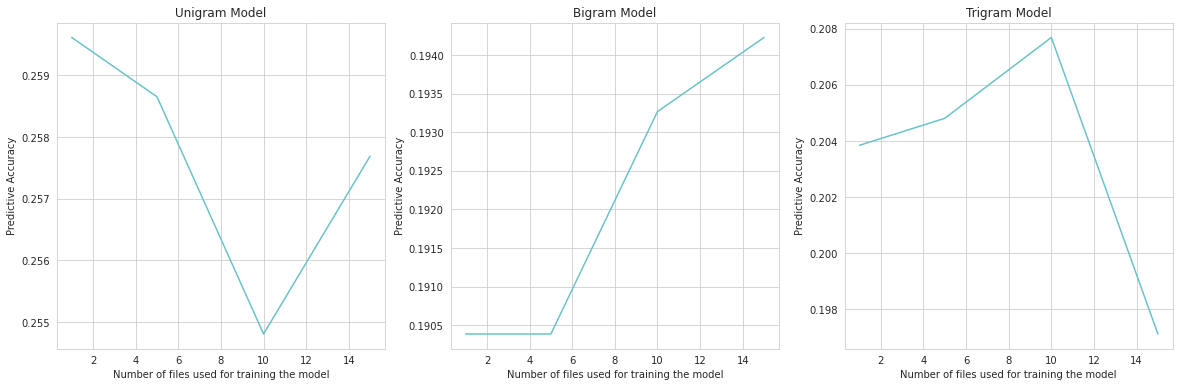

In [257]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6))
axs[0].plot('Number of training files', 'Accuracy', data = small_size_scores['Unigram'], color = '#6ac2c9')
axs[0].set_title('Unigram Model')
axs[0].set_xlabel('Number of files used for training the model')
axs[0].set_ylabel('Predictive Accuracy')
axs[1].plot('Number of training files', 'Accuracy', data = small_size_scores['Bigram'], color = '#6ac2c9')
axs[1].set_title('Bigram Model')
axs[1].set_xlabel('Number of files used for training the model')
axs[1].set_ylabel('Predictive Accuracy')
axs[2].plot('Number of training files', 'Accuracy', data = small_size_scores['Trigram'], color = '#6ac2c9')
axs[2].set_title('Trigram Model')
axs[2].set_xlabel('Number of files used for training the model')
axs[2].set_ylabel('Predictive Accuracy')
sns.set_style('whitegrid')
# ax.set_xlabel('Number of files used for training the model')
# ax.set_ylabel('Predictive Accuracy')

Text(0.5, 1.0, 'Predictive Accuracy scores for each model for differing training file size')

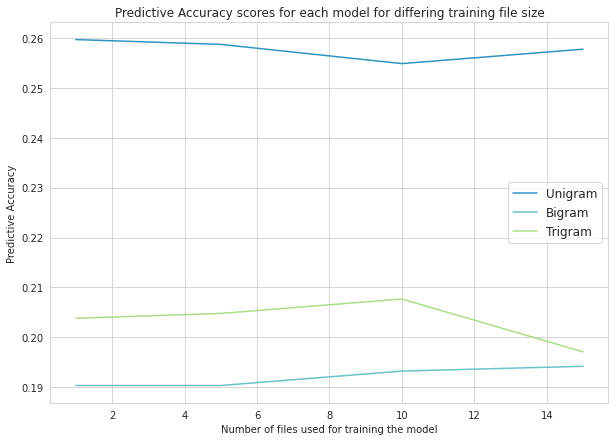

In [192]:
plt.figure(figsize = (10, 7))
ax = sns.lineplot(x = 'Number of training files', y = 'Accuracy', data = small_size_scores['Unigram'], color = '#3092c1')
ax = sns.lineplot(x = 'Number of training files', y = 'Accuracy', data = small_size_scores['Bigram'], color = '#6ac2c9')
ax = sns.lineplot(x = 'Number of training files', y = 'Accuracy', data = small_size_scores['Trigram'], color = '#aade86')  

sns.set_style('whitegrid')
ax.set_xlabel('Number of files used for training the model')
ax.set_ylabel('Predictive Accuracy')
plt.legend(['Unigram', 'Bigram', 'Trigram'], fontsize = 'large')
plt.title('Predictive Accuracy scores for each model for differing training file size')

In [173]:
# FIX NESTED DICTIONARY APPENDS :((
def run_ngram_model(filesizes = (), methods = []):
  size_scores = {'Method': [], 'Results': {'Number of training files': [], 'Accuracy': []}}
  for method in methods:
    size_scores['Method'].append(method)
    for size in filesizes:
      mylm = language_model(files = trainingfiles[:size])
      SCC = scc_reader()
      acc_score = SCC.predict_and_score(method = method)
      size_scores['Results']['Number of training files'].append(size)
      size_scores['Results']['Accuracy'].append(acc_score)
  return size_scores

In [ ]:
filesizes = (1, 5, 10, 50)
methods = ('unigram', 'bigram', 'trigram')
size_scores = run_ngram_model(filesizes = filesizes, methods = methods)

In [178]:
size_scores

{'Method': ['unigram', 'bigram', 'trigram'],
 'Results': {'Accuracy': [0.2567307692307692,
   0.2528846153846154,
   0.25769230769230766,
   0.2528846153846154,
   0.19423076923076923,
   0.19615384615384615,
   0.1971153846153846,
   0.1951923076923077,
   0.20673076923076922,
   0.20288461538461539,
   0.2048076923076923,
   0.18461538461538463],
  'Number of training files': [1, 5, 10, 50, 1, 5, 10, 50, 1, 5, 10, 50]}}

#### Evaluation Metric: Perplexity

Perplexity is the normalised inverse probability of the test set. If a model assigns a high probability to the test set, it means that it is **not surprised** to see it (it's not *perplexed* by it), which means that it has a good understanding of how the language works. A lower perplexity indicates a better model.

Given our set of test sentences, $W$, and the number of tokens in the test set $n$, perplexity can be calculated by:

$$ PP(W) = \frac{1}{P(w_{1}, w_{2}, ..., w_{n})^ \frac{1}{n}} $$

$$ PP(W) = n \sqrt{\frac{1}{P(w_{1}, w_{2}, ..., w_{n})}} $$

#### Evaluation Metric: Average Log Likelihood

$$ P_{eval}(text) = \prod \limits _{word} P_{train}(word) $$

$$ log(P_{eval}(text)) = \sum \limits _{word} log(P_{train}(word)) $$

$$ Average Log Likelihood_{eval} = \frac{\sum \limits _{word} log(P_{train}(word))}{N_{eval}} $$

## Neural Language Model

Using the Pytorch Library to build a Feed-Forward Neural Language Model

In [90]:
CONTEXT_SIZE = 2  # number of preceeding words to consider
EMBEDDING_DIM = 10  # dimension of the embeddings
MAX_FILES = 1

In [99]:
class NGramLanguageModeler(nn.Module):
  def __init__(self, vocab_size, embedding_dim = EMBEDDING_DIM, 
               context_size = CONTEXT_SIZE):
    super(NGramLanguageModeler, self).__init__()
    self.embedding_dim = embedding_dim
    self.context_size = context_size
    self.hidden_size = 128
    self.threshold = 20

  def initialise(self):
    self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
    self.linear1 = nn.Linear(self.context_size * self.embedding_dim, self.hidden_size)
    self.linear2 = nn.Linear(self.hidden_size, self.vocab_size)

  def forward(self, inputs):
    embeds = self.embeddings(inputs).view((1, -1))
    out = F.relu(self.linear1(embeds))
    out = self.linear2(out)
    log_probs = F.log_softmax(out, dim=1)
    return log_probs

  def get_logprob(self, context, target):
    #return the logprob of the target word given the context
    context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype = torch.long)
    log_probs = self.forward(context_idxs)
    target_idx = torch.tensor(self.word_to_ix[target], dtype = torch.long)
    return log_probs.index_select(1, target_idx).item()
          
  def nextlikely(self, context):
    #sample the distribution of target words given the context
    context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype = torch.long)
    log_probs = self.forward(context_idxs)
    probs = [math.exp(x) for x in log_probs.flatten().tolist()]
    t = random.choices(list(range(len(probs))), weights = probs, k = 1)
    return self.ix_to_word[t[0]]
  
  def generate(self, limit = 20):
    #generate a sequence of tokens according to the model
    tokens = ['</s>', '<s>']
    while tokens[-1] != '</s>' and len(tokens) < limit:
      current = self.nextlikely(tokens[-2:])
      tokens.append(current)
    return ' '.join(tokens[2:-1])

  def train(self, inputngrams, loss_function = nn.NLLLoss(), lr = 0.001, epochs = 10):
    optimizer = optim.SGD(self.parameters(), lr = lr)
    losses = []
    for epoch in tqdm(range(epochs)):
      total_loss = 0
      for context, target in inputngrams:
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype = torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        self.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = self.forward(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([self.word_to_ix[target]], dtype = torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
          
        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
      losses.append(total_loss)
    print(losses)

  def train_from_corpus(self, training_dir = TRAINING_DIR, files = []):
    alltokens = ['</s>']
    #reading corpus and tokenize
    for afile in files:
      print('Reading {}'.format(afile))
      try:
        with open(os.path.join(training_dir, afile)) as instream:
          for line in instream:
            line = line.rstrip()
            if len(line) > 0:
              tokens = ['<s>'] + tokenize(line) + ['</s>']
              alltokens += tokens
      except UnicodeDecodeError:
        print('UnicodeDecodeError reading {}: ignoring file'.format(afile))
    
    #get the vocab and build the indexes
    self.vocab = {}
    for token in alltokens:
      self.vocab[token] = self.vocab.get(token, 0) + 1

    #delete unknown words from the vocab
    unknowns = 0
    for key, value in list(self.vocab.items()):
      if value < self.threshold:
        unknowns += value
        self.vocab.pop(key, None)
    self.vocab['<unk>'] = unknowns

    self.word_to_ix = {word: i for i, word in enumerate(list(self.vocab.keys()))}
    self.ix_to_word = {i: word for i, word in enumerate(list(self.vocab.keys()))}
    
    #MUST SET THE VOCAB SIZE and INITIALISE THE NN
    self.vocab_size = len(self.vocab) 
    print('Vocabulary size is {}'.format(self.vocab_size))
    self.initialise()

    #replace the unknown tokens
    filteredtokens = []
    for token in alltokens:
      if token in self.vocab.keys():
        filteredtokens.append(token)
      else:
        filteredtokens.append('<unk>')
    
    #convert to trigrams
    trigrams = [([filteredtokens[i], filteredtokens[i + 1]], filteredtokens[i + 2])
      for i in range(len(filteredtokens) - 2)]
    
    print('Starting training')
    #train using the trigrams
    self.train(trigrams)

In [100]:
nn_model = NGramLanguageModeler(EMBEDDING_DIM, CONTEXT_SIZE)
nn_model.train_from_corpus(files = trainingfiles[:MAX_FILES])

[325.05508399009705, 323.04392743110657, 321.05185317993164, 319.0786497592926, 317.12340021133423, 315.1858367919922, 313.2658715248108, 311.36226296424866, 309.47515392303467, 307.6039571762085]


In [101]:
nn_model.generate()

"gazed gazed weed deep To . where where eyes To 's small deep gazed all-eating And lusty"